# POD-DL-ROMs for the resolution of Hemodynamic PDEs

---
## 1 Data Preparation


#### Import useful libraries

In [1]:
from data_handler import *
from ML_handler import *
from plot_handler import *
from models import *
import seaborn as sns
%load_ext autoreload
%autoreload 2

In [2]:
def set_seed(seed):
    """Set the seed for reproducibility

    Args:
        seed: int representing the chosen seed
    """
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

#Fix the seed
set_seed(50)

In [3]:
#Choose the device to use

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("You are currently using", device)

You are currently using cuda


#### Import and Preprocess Data

In [4]:
#load parameters, solutions, and useful data
params, solutions, basis_space, basis_time, Nh_space, Nh_time = load_params()

In [5]:
#Convert from numpy to tensor

solutions= torch.tensor(solutions, dtype=torch.float32)
params = torch.tensor(params, dtype=torch.float32)

n_p, rwos_p = params.shape
n_v, rwos_v, cols_v = solutions.shape
print("The shape of the parameters data is", (n_p, rwos_p), "and the shape of the reduced velocities is", (n_v, rwos_v, cols_v))

The shape of the parameters data is (1950, 3) and the shape of the reduced velocities is (1950, 39, 16)


In [6]:
#Split params in train and test with a ratio of 80%/20%
N_data=params.shape[0]
indices = torch.randperm(N_data)
ratio_data=0.8
train_size = int(ratio_data * N_data)
train_indices = indices[:train_size]
test_indices=indices[train_size:]

train_params=params[train_indices]
test_params=params[test_indices]

#Standardize parameters in [0,1] (the ranges are known)
min_params= torch.tensor([4, 0.1, 0.2], dtype=torch.float32)
max_params= torch.tensor([8, 0.3, 0.8], dtype=torch.float32)

train_params = normalize(train_params, min_params, max_params)
test_params = normalize(test_params, min_params, max_params)

#Split velocity in train and test
train_vel=solutions[train_indices]
test_vel=solutions[test_indices]

#Standardize parameters in [0,1] with a margin
vel_space_max = torch.max(solutions, dim= 0).values
vel_space_min = torch.min(solutions, dim=0).values

train_vel = normalize(train_vel, vel_space_min, vel_space_max, margin=0.05)
test_vel = normalize(test_vel, vel_space_min, vel_space_max, margin=0.05)

---
## 2 Training

#### **Hyperparameters optimization**


#### Learning rate


As the parameters to be tuned are many, we start iterating on different learning rates to see the best values.
Since the optimum learning rate and number of epochs for good training should not vary too much with a small change in the architecture, we expect that the good values found for the fixed architecture will also perform well with a slight change in the architecture in the following steps.

We train the model with a reasonable architecture by varying the learning rate, keeping the number of epochs sufficiently large, to see which learning rate determines the best performance

In [7]:
#Set a standard structure for the model architecture
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400

#Values of learning rate
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]

final_train_losses_lr = np.zeros((len(lr_values),))
final_val_losses_lr = np.zeros((len(lr_values),))
final_val_rel_losses_lr = np.zeros((len(lr_values),))

train_losses_lr = []
val_losses_lr = []
val_rel_losses_lr = []

for idx, lr in enumerate(lr_values):

        #train the model
        model_trained, train_loss_history, val_loss_history, val_rel_loss_history,  train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=L_enc_dec,),
        num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel, device,  vel_space_max, vel_space_min, weights = [1,1])

        #extract values corresponding to epoch = num_epoch (last values of the lists)
        final_train_losses_lr[idx] = train_loss_history[-1]
        final_val_losses_lr[idx] = val_loss_history[-1]
        final_val_rel_losses_lr[idx] = val_rel_loss_history[-1]

        train_losses_lr.append(train_loss_history)
        val_losses_lr.append(val_loss_history)
        val_rel_losses_lr.append(val_rel_loss_history)

        print("Optimization for lr=",lr, "finished!")


for idx, lr in enumerate(lr_values):
    print(f"LR = {lr}, Train_loss = {final_train_losses_lr[idx]:.4f}, Test_loss = {final_val_losses_lr[idx]:.4f}, test_relative_error = {final_val_rel_losses_lr[idx]:.4f}")

Optimization for lr= 0.0001 finished!
Optimization for lr= 0.0005 finished!
Optimization for lr= 0.001 finished!
Optimization for lr= 0.005 finished!
Optimization for lr= 0.01 finished!
Optimization for lr= 0.05 finished!
LR = 0.0001, Train_loss = 0.0023, Test_loss = 0.0026, test_relative_error = 0.0282
LR = 0.0005, Train_loss = 0.0014, Test_loss = 0.0016, test_relative_error = 0.0253
LR = 0.001, Train_loss = 0.0014, Test_loss = 0.0016, test_relative_error = 0.0247
LR = 0.005, Train_loss = 1.6542, Test_loss = 1.6603, test_relative_error = 0.1707
LR = 0.01, Train_loss = 0.0372, Test_loss = 0.0386, test_relative_error = 0.0252
LR = 0.05, Train_loss = 1.6653, Test_loss = 1.6637, test_relative_error = 0.2703


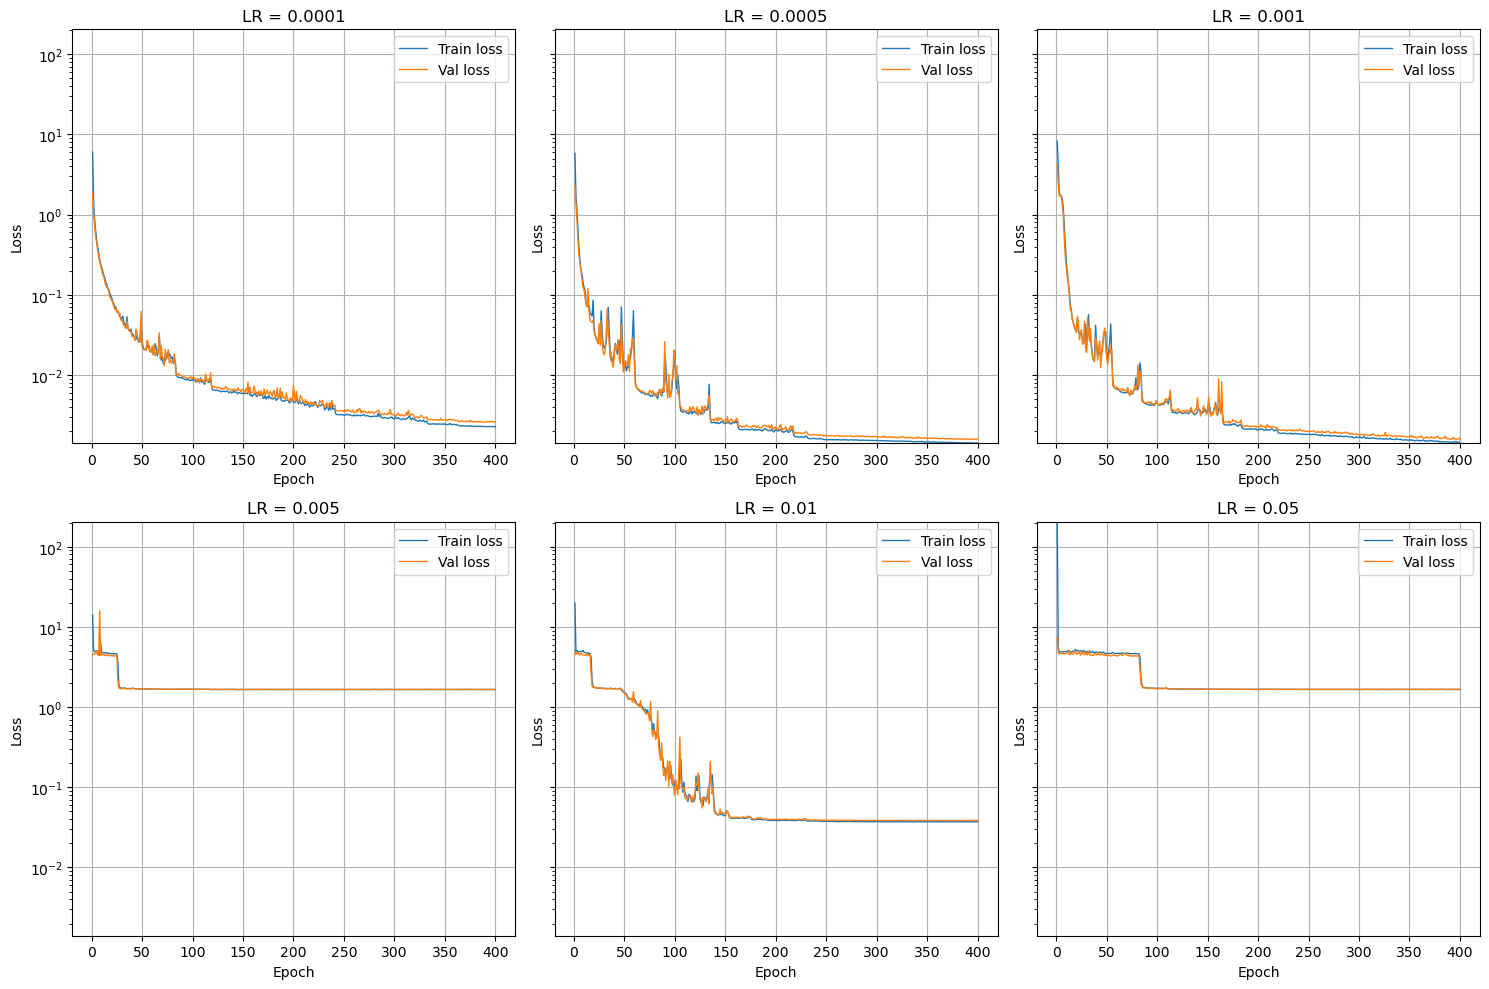

In [8]:
#Plot the graphs changing the learning rate

fig, ax = plt.subplots(2, 3, figsize=(15, 10), sharey=True)

#We fix these values to give a limit to the y-axis of the graphs
y_min = float('inf')
y_max = -float('inf')

################
L_enc_dec=3
dim_reduced = 128
batch_size=32
num_epochs=400
lr_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2]
################

for idx, lr in enumerate(lr_values):

    row = idx // 3
    col = idx % 3

    plot(ax[row, col], train_losses_lr[idx], val_losses_lr[idx], num_epochs)
    ax[row, col].set_title(f"LR = {lr}")
    y_max = max(y_max, max(np.max(train_losses_lr[idx]), np.max(val_losses_lr[idx]), np.max(val_rel_losses_lr[idx])))
    y_min = min(y_min, min(np.min(train_losses_lr[idx]), np.min(val_losses_lr[idx]), np.min(val_rel_losses_lr[idx])))


for i in range(2):
    for j in range(3):
        ax[i, j].set_ylim(y_min, y_max)


plt.tight_layout()
plt.show()

In [9]:
#Extracting the LR with the highest performance

best_index_lr=np.argmin(final_val_rel_losses_lr)
best_lr = lr_values[best_index_lr]
best_num_epochs=400
print("The best LR is", best_lr,"with", num_epochs, "epochs, with a relative error of", np.min(final_val_rel_losses_lr))

The best LR is 0.001 with 400 epochs, with a relative error of 0.024657344818115233


#### Autoencoder Layers & Latent dimension


Having found proper values for the learning rate and the number of epochs, we optimize for the architecture of the network

In [10]:
l_values = [1, 2, 3, 4]                   #number of layers in the encoder (=decoder)
dim_reduced_list = [16, 32, 64, 128, 256] #output dimension of the encoder (latent dimension)


final_train_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_val_losses_matrix= np.zeros((len(l_values), len(dim_reduced_list)))
final_rel_losses_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_dec_matrix = np.zeros((len(l_values), len(dim_reduced_list)))
final_losses_enc_solver_matrix = np.zeros((len(l_values), len(dim_reduced_list)))

train_losses_L_dimreduced=[]
val_losses_L_dimreduced=[]
rel_losses_L_dimreduced=[]
losses_enc_solver_L_dimreduced=[]
losses_enc_dec_L_dimreduced=[]

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):

        model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(dim_reduced=dim_reduced, activation="gelu", L_enc_dec=l),
        best_num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, vel_space_max, vel_space_min, weights=[1,1])

        final_train_losses_matrix[idx_l, idx_dim_reduced] = train_loss_history[-1]
        final_val_losses_matrix[idx_l, idx_dim_reduced] = val_loss_history[-1]
        final_rel_losses_matrix[idx_l, idx_dim_reduced] = val_rel_loss_history[-1]
        final_losses_enc_dec_matrix[idx_l, idx_dim_reduced] = train_loss_enc_dec_history[-1]
        final_losses_enc_solver_matrix[idx_l, idx_dim_reduced] = train_loss_solver_enc_history[-1]


        train_losses_L_dimreduced.append(train_loss_history)
        val_losses_L_dimreduced.append(val_loss_history)
        rel_losses_L_dimreduced.append(val_rel_loss_history)
        losses_enc_dec_L_dimreduced.append(train_loss_enc_dec_history)
        losses_enc_solver_L_dimreduced.append(train_loss_solver_enc_history)
        
        print("Optimization for L=",l,"and latent dimension=", dim_reduced, "finished!")

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
       print(f"Layers = {l}, dim_reduced = {dim_reduced}, Train_loss = {final_train_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, Test_loss = {final_val_losses_matrix[idx_l,idx_dim_reduced ]:.4f}, test_relative_error = {final_rel_losses_matrix[idx_l,idx_dim_reduced ]:.4f}")

Optimization for L= 1 and latent dimension= 16 finished!
Optimization for L= 1 and latent dimension= 32 finished!
Optimization for L= 1 and latent dimension= 64 finished!
Optimization for L= 1 and latent dimension= 128 finished!
Optimization for L= 1 and latent dimension= 256 finished!
Optimization for L= 2 and latent dimension= 16 finished!
Optimization for L= 2 and latent dimension= 32 finished!
Optimization for L= 2 and latent dimension= 64 finished!
Optimization for L= 2 and latent dimension= 128 finished!
Optimization for L= 2 and latent dimension= 256 finished!
Optimization for L= 3 and latent dimension= 16 finished!
Optimization for L= 3 and latent dimension= 32 finished!
Optimization for L= 3 and latent dimension= 64 finished!
Optimization for L= 3 and latent dimension= 128 finished!
Optimization for L= 3 and latent dimension= 256 finished!
Optimization for L= 4 and latent dimension= 16 finished!
Optimization for L= 4 and latent dimension= 32 finished!
Optimization for L= 4 and

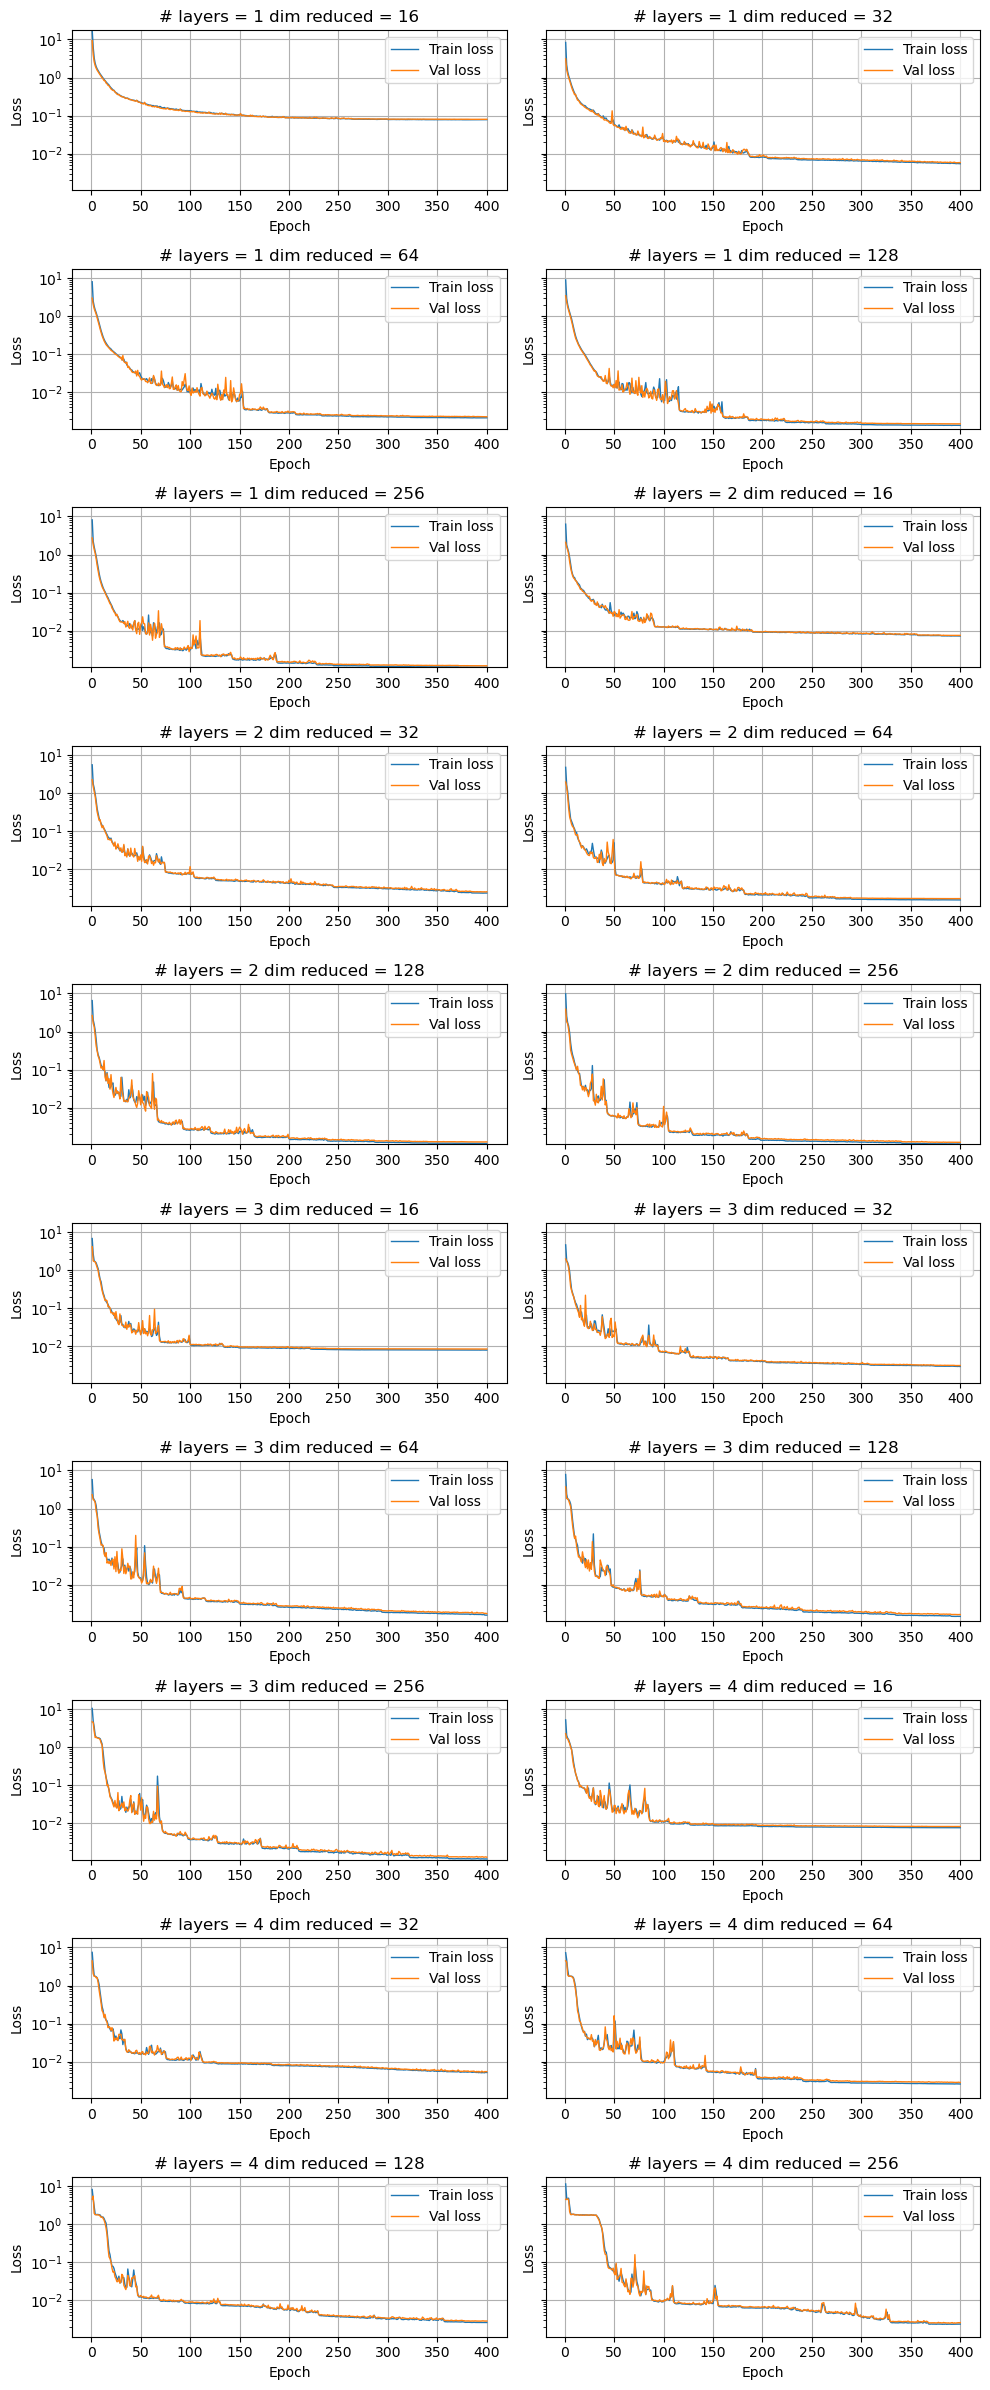

In [11]:
#Plot the graphs

fig, ax = plt.subplots(10, 2, figsize=(10, 24), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_l, l in enumerate(l_values):
   for idx_dim_reduced,  dim_reduced in enumerate(dim_reduced_list):
        
        subplot_index = idx_l * len(dim_reduced_list) + idx_dim_reduced
        row = subplot_index // 2
        col = subplot_index % 2

        plot(ax[row, col], train_losses_L_dimreduced[subplot_index], val_losses_L_dimreduced[subplot_index],  best_num_epochs)
        ax[row, col].set_title(f"# layers = {l} dim reduced = {dim_reduced}", )
        y_max = max(y_max, max(np.max(train_losses_L_dimreduced[subplot_index]), np.max(val_losses_L_dimreduced[subplot_index]), np.max(rel_losses_L_dimreduced[subplot_index])))
        y_min = min(y_min, min(np.min(train_losses_L_dimreduced[subplot_index]), np.min(val_losses_L_dimreduced[subplot_index]), np.min(rel_losses_L_dimreduced[subplot_index])))


for i in range(10):
    for j in range(2):
        ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()


In [12]:
#Extracting the architecture with the highest performance

total_paramaters_matrix=np.zeros((len(l_values), len(dim_reduced_list)))

for idx_l in range(len(l_values)):
    for idx_dim in range(len(dim_reduced_list)):
        model_ = SolverPlusMLPAutoencoder(dim_reduced=dim_reduced_list[idx_dim], activation="gelu", L_enc_dec=l_values[idx_l])
        total_params = sum(p.numel() for p in model_.parameters())
        total_paramaters_matrix[idx_l, idx_dim] = total_params

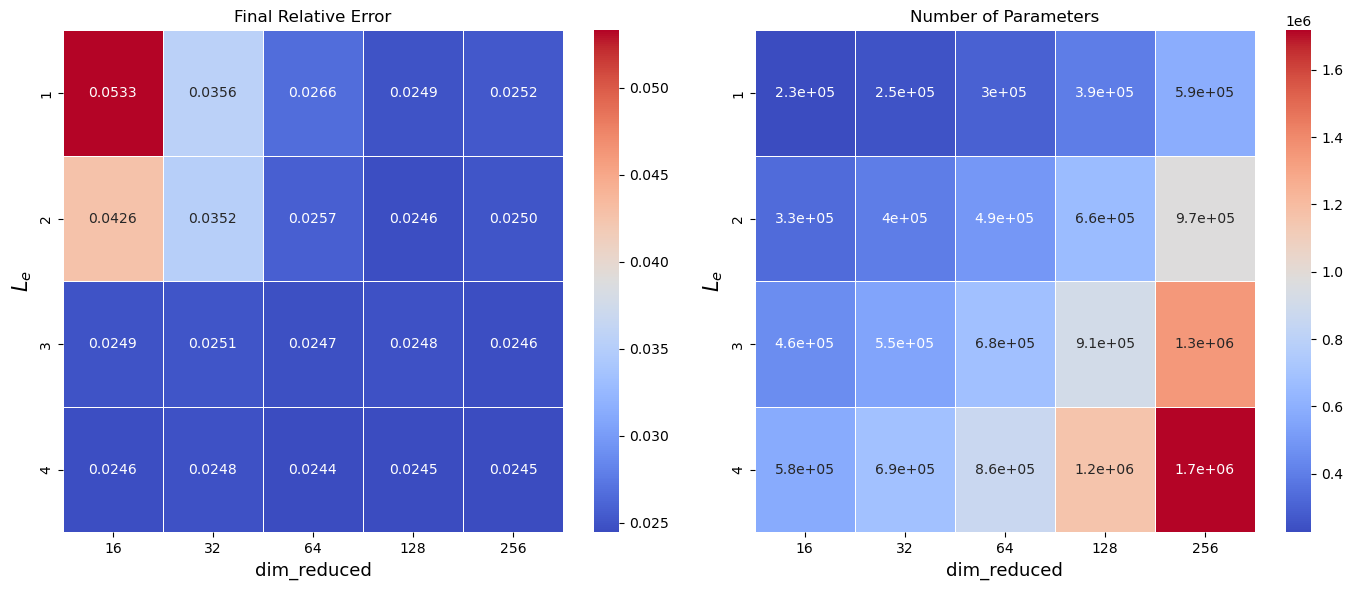

In [13]:
#Plotting how the performance change with the complexity of the network
fig, axes = plt.subplots(1, 2, figsize=(14, 6)) 

sns.heatmap(final_rel_losses_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=0.5, 
            yticklabels=['1', '2', '3', '4'], xticklabels=['16', '32', '64', '128', '256'], ax=axes[0])
axes[0].set_title("Final Relative Error")
axes[0].set_xlabel("dim_reduced", fontsize=13)
axes[0].set_ylabel(r'$L_e$', fontsize=15)

sns.heatmap(total_paramaters_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            yticklabels=['1', '2', '3', '4'], xticklabels=['16', '32', '64', '128', '256'], ax=axes[1])
axes[1].set_title("Number of Parameters")
axes[1].set_xlabel("dim_reduced", fontsize=13)
axes[1].set_ylabel(r'$L_e$', fontsize=15)

plt.tight_layout()
plt.show()

Other than minimizing the error, our aim is also to minimize the number of trainable paramteres in the model and to compress the input velocity as much as possible (minimze dim_reduced). Consequently, choosing a threshold for the relative error of 2.5%, a model with dim_reduced=32 and #Layers=4 represents a good compromise between the above mentioned goals and the need to guarantee a margin of the error with respect to the chosen threshold, given that the robustness of the model has not been tested yet.

In [14]:
#Extracting the best model changing layers in the autoencoder and latent dimension

best_L_enc_dec = 4
best_dim_reduced = 32
best_index=16

print(f"best_L_enc_dec = {best_L_enc_dec}, best_dim_reduced = {best_dim_reduced}, with a relative error of", final_rel_losses_matrix[3,1])

best_L_enc_dec = 4, best_dim_reduced = 32, with a relative error of 0.02479300464575107


#### Observe the trend of the two components of the loss for the best model

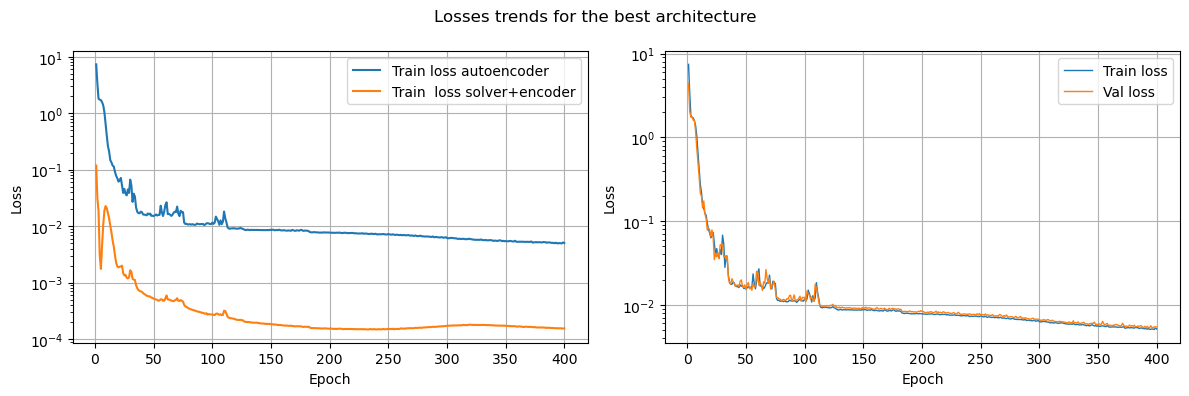

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

t = np.arange(1, num_epochs + 1)

axes[0].semilogy(t, losses_enc_dec_L_dimreduced[best_index], label="Train loss autoencoder")
axes[0].semilogy(t, losses_enc_solver_L_dimreduced[best_index], label="Train  loss solver+encoder")
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].grid(True) 

axes[1].semilogy(t, train_losses_L_dimreduced[best_index], label="Train loss", linewidth=1)
axes[1].semilogy(t, val_losses_L_dimreduced[best_index], label="Val loss", linewidth=1)
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].grid(True) 

fig.suptitle("Losses trends for the best architecture")
plt.tight_layout()
plt.show()

The difference in magnitude between the two components of the losse leads to analyze how their contribute to the global loss should be weighted.
Therefore we perform some optimizations varying their weights in the sum, given the number of epochs, the learning rate, the number of layers in the autoencoder and the latent dimension

#### Weight $w$  ($\mathcal{L}_{autoenc}+w\mathcal{L}_{enc,solv}$)

In [16]:
#Varying the parameter w
w_values=[1/100,1/10,1/5,5,10,100]
num_epochs=500


final_train_losses_w = np.zeros((len(w_values),))
final_val_losses_w= np.zeros((len(w_values),))
final_val_rel_losses_w = np.zeros((len(w_values),))
final_losses_enc_dec_w = np.zeros((len(w_values),))
final_losses_enc_solver_w = np.zeros((len(w_values),))

train_losses_w = []
val_losses_w = []
val_rel_losses_w = []
losses_enc_dec_w = []
losses_enc_solver_w = []

for idx_w, w_value in enumerate(w_values):

      model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
      SolverPlusMLPAutoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec,),
      num_epochs, best_lr, batch_size, train_params, train_vel, test_params, test_vel, device, vel_space_max, vel_space_min, weights=[1,w_value])

      final_train_losses_w[idx_w] = train_loss_history[-1]
      final_val_losses_w[idx_w] = val_loss_history[-1]
      final_val_rel_losses_w[idx_w] = val_rel_loss_history[-1]
      final_losses_enc_dec_w[idx_w] = train_loss_enc_dec_history[-1]
      final_losses_enc_solver_w[idx_w] = train_loss_solver_enc_history[-1]

      train_losses_w.append(train_loss_history)
      val_losses_w.append(val_loss_history)
      val_rel_losses_w.append(val_rel_loss_history)
      losses_enc_dec_w.append(train_loss_enc_dec_history)
      losses_enc_solver_w.append(train_loss_solver_enc_history)

      print("Optimization for w=", w_value, "finished!")


for idx_w, w_value in enumerate(w_values):
    print(f"Weight value = {w_value}, Train_loss = {final_train_losses_w[idx_w]:.4f}, Test_loss = {final_val_losses_w[idx_w]:.4f}, test_relative_error = {final_val_rel_losses_w[idx_w]:.4f}")

Optimization for w= 0.01 finished!
Optimization for w= 0.1 finished!
Optimization for w= 0.2 finished!
Optimization for w= 5 finished!
Optimization for w= 10 finished!
Optimization for w= 100 finished!
Weight value = 0.01, Train_loss = 0.0064, Test_loss = 0.0069, test_relative_error = 0.0596
Weight value = 0.1, Train_loss = 0.0028, Test_loss = 0.0031, test_relative_error = 0.0254
Weight value = 0.2, Train_loss = 0.0035, Test_loss = 0.0038, test_relative_error = 0.0250
Weight value = 5, Train_loss = 0.0049, Test_loss = 0.0052, test_relative_error = 0.0246
Weight value = 10, Train_loss = 0.0037, Test_loss = 0.0040, test_relative_error = 0.0250
Weight value = 100, Train_loss = 0.0050, Test_loss = 0.0055, test_relative_error = 0.0247


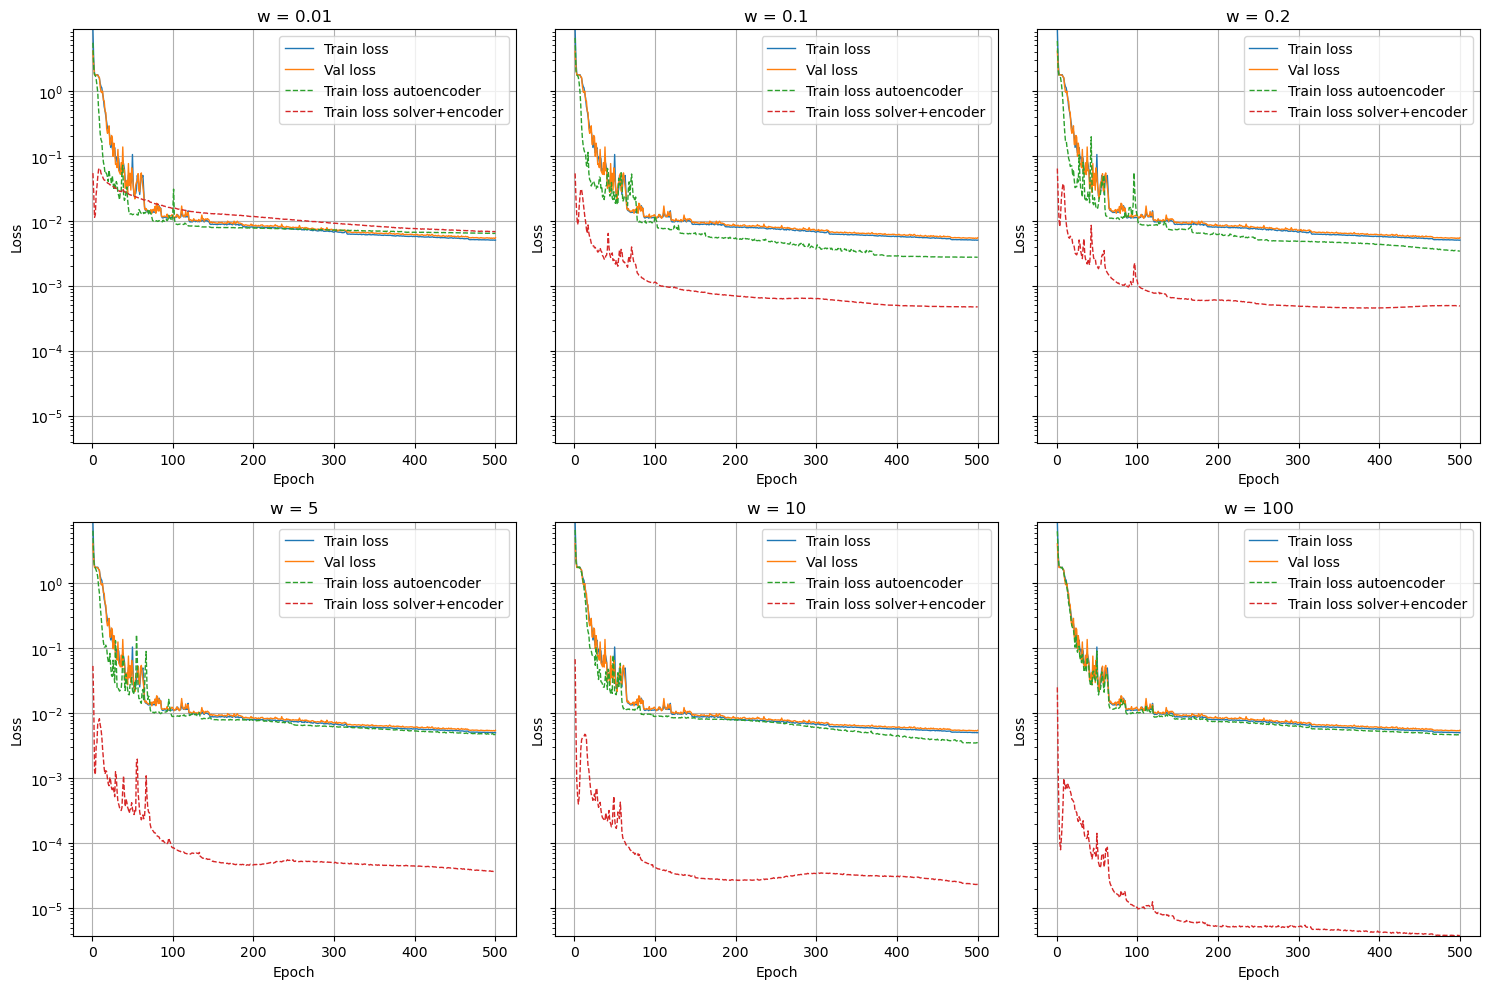

In [17]:
#Plot the graphs changing w

fig, ax = plt.subplots(2, 3 , figsize=(15, 10), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_w, w_value in enumerate(w_values):
      row = idx_w // 3
      col = idx_w % 3

      #plot the graphs
      plot(ax[row,col], train_losses_w[idx], val_losses_w[idx], num_epochs)
      t = np.arange(1, num_epochs + 1)
      ax[row, col].semilogy(t, losses_enc_dec_w[idx_w], label="Train loss autoencoder", linewidth=1, linestyle="--")
      ax[row, col].semilogy(t, losses_enc_solver_w[idx_w], label="Train loss solver+encoder", linewidth=1, linestyle="--")
      ax[row, col].legend()
      ax[row, col].set_title(f"w = {w_value}")
      y_max = max(y_max, max(np.max(train_losses_w[idx_w]), np.max(val_losses_w[idx_w]), np.max(losses_enc_dec_w[idx_w]), np.max(losses_enc_solver_w[idx_w])))
      y_min = min(y_min, min(np.min(train_losses_w[idx_w]), np.min(val_losses_w[idx_w]), np.min(losses_enc_dec_w[idx_w]), np.min(losses_enc_solver_w[idx_w])))

for i in range(2):
  for j in range(3):
      ax[i, j].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

In [18]:
#Extracting the best model changing w
best_index=np.argmin(final_val_rel_losses_w)

best_w=w_values[best_index]
print(f"best w = {best_w}, with a relative error of", np.min(final_val_rel_losses_w))

best w = 5, with a relative error of 0.02459648786446987


Since the optimization of w does not modify significantly the best relative error, it will be set anyway to w=1

#### **Sequential Training**

We investigate how the performance changes applying a sequential training. First, the autoencoder is trained. Then, the solver is trained to reproduce the output of the encoder.

The hyperparameters used in this section are the best hyperparamaters found above

#### Training Autoencoder

In [19]:
#Training

num_epochs=600

autoencoder_trained, train_loss_history_autoenc, val_loss_history_autoenc = run_training(
        Autoencoder(dim_reduced=best_dim_reduced, activation="gelu", L_enc_dec=best_L_enc_dec), 
        num_epochs, best_lr, batch_size,  train_params, train_vel, test_params, test_vel, vel_space_max, vel_space_min, device)

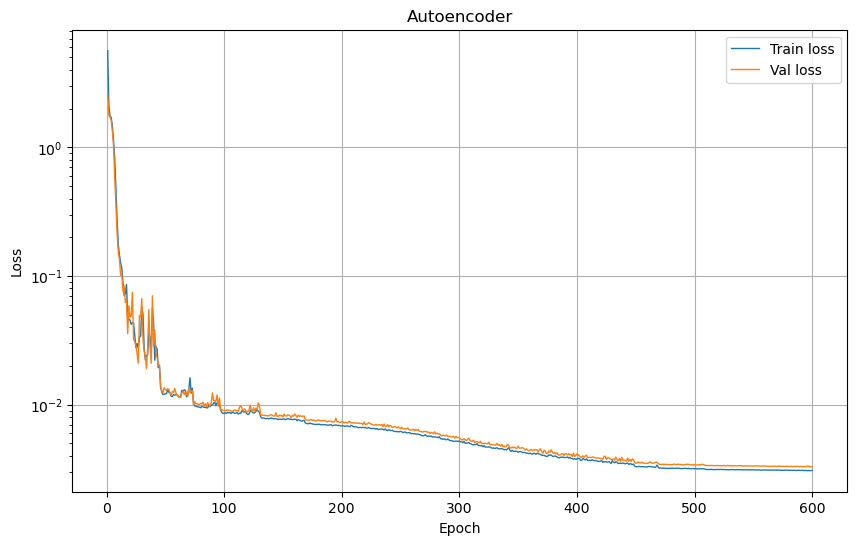

The loss obtained after the optimization is: 0.003283570136110752


In [20]:
#Plotting results for the Autoencoder
fig, ax = plt.subplots(figsize=(10, 6))
plot(ax, train_loss_history_autoenc, val_loss_history_autoenc, num_epochs)
ax.set_title(f"Autoencoder")
ax.grid(True)
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_autoenc[-1])

In [21]:
#training Solver

num_epochs=250

solver_trained, train_loss_history_solver, val_loss_history_solver = run_training_solver(
        autoencoder_trained,
        Solver(dim_reduced=best_dim_reduced),
        num_epochs, 0.01, batch_size, train_params, train_vel, test_params, test_vel, device)

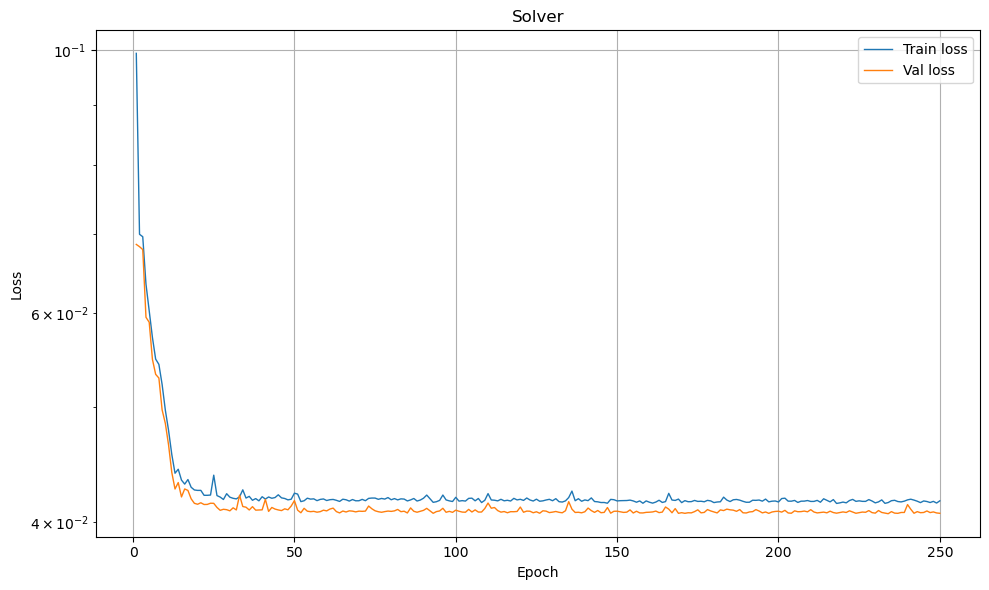

The loss obtained after the optimization is: 0.040684521828706445


In [22]:
#Plotting results for the solver

fig, ax = plt.subplots(figsize=(10, 6))
plot(ax, train_loss_history_solver, val_loss_history_solver, num_epochs)
ax.set_title(f"Solver")
ax.grid(True)
plt.tight_layout()
plt.show()

print("The loss obtained after the optimization is:", val_loss_history_solver[-1])

The trend of the loss for the solver shows that the hyperparameters chosen for the global network do not succeed in determining a good performance in the sequential training

In [23]:
#Performance Evaluation of Sequential Training

solver_trained.eval()
autoencoder_trained.eval()

err_rel=0
with torch.no_grad():
  for (param, vel) in zip(test_params, test_vel):

    param=param.unsqueeze(dim=0)
    param=param.to(device)

    vel=vel.to(device)

    vel_reduced_predict=solver_trained(param)
    vel_predict=autoencoder_trained.decoder(vel_reduced_predict)

    vel_predict=vel_predict.squeeze(dim=0)

    vel_predict=denormalize(vel_predict, vel_space_min, vel_space_max, margin=0.05)
    vel=denormalize(vel, vel_space_min, vel_space_max, margin=0.05)

    err_rel+=torch.norm(vel_predict-vel)/torch.norm(vel)

  err_rel=err_rel.item()/len(test_params)
  print("The validation test relative error for the sequential training is: ", err_rel)


The validation test relative error for the sequential training is:  0.2213628133138021


#### **Convolutional Autoencoder**

We try to evaluate how the network performs with using a ConvNet for the autoencoder

In [24]:
activation="gelu"
pooling="avg"
K_comb=[5,1,2]
lr=0.001
num_epochs=500

Lc_Ll_list=[(2,2),(2,3),(3,2)]  

final_train_losses_conv = np.zeros((len(Lc_Ll_list),))
final_val_losses_conv= np.zeros((len(Lc_Ll_list),))
final_val_rel_losses_conv = np.zeros((len(Lc_Ll_list),))

train_losses_conv = []
val_losses_conv = []
val_rel_losses_conv = []

for idx_conv, el in enumerate(Lc_Ll_list):
    L_c=el[0]
    L_l=el[1]
    model_trained, train_loss_history,  val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusConvAutoencoder(activation, pooling, K_comb, L_c, L_l,  dim_reduced=best_dim_reduced), num_epochs, lr, batch_size, train_params, train_vel, test_params, test_vel,  device, vel_space_max, vel_space_min)

    final_train_losses_conv[idx_conv] = train_loss_history[-1]
    final_val_losses_conv[idx_conv] = val_loss_history[-1]
    final_val_rel_losses_conv[idx_conv] = val_rel_loss_history[-1]

    train_losses_conv.append(train_loss_history)
    val_losses_conv.append(val_loss_history)
    val_rel_losses_conv.append(val_rel_loss_history)

    print("Optimization for (L_c, L_l)=", el, "finished!")

for idx_conv, el in enumerate(Lc_Ll_list):
    print(f"(L_c, L_l) = {el}, Train_loss = {final_train_losses_conv[idx_conv]:.4f}, Test_loss = {final_val_losses_conv[idx_conv]:.4f}, test_relative_error = {final_val_rel_losses_conv[idx_conv]:.4f}")

Optimization for (L_c, L_l)= (2, 2) finished!
Optimization for (L_c, L_l)= (2, 3) finished!
Optimization for (L_c, L_l)= (3, 2) finished!
(L_c, L_l) = (2, 2), Train_loss = 0.0085, Test_loss = 0.0097, test_relative_error = 0.0268
(L_c, L_l) = (2, 3), Train_loss = 0.0096, Test_loss = 0.0104, test_relative_error = 0.0260
(L_c, L_l) = (3, 2), Train_loss = 0.0102, Test_loss = 0.0109, test_relative_error = 0.0263


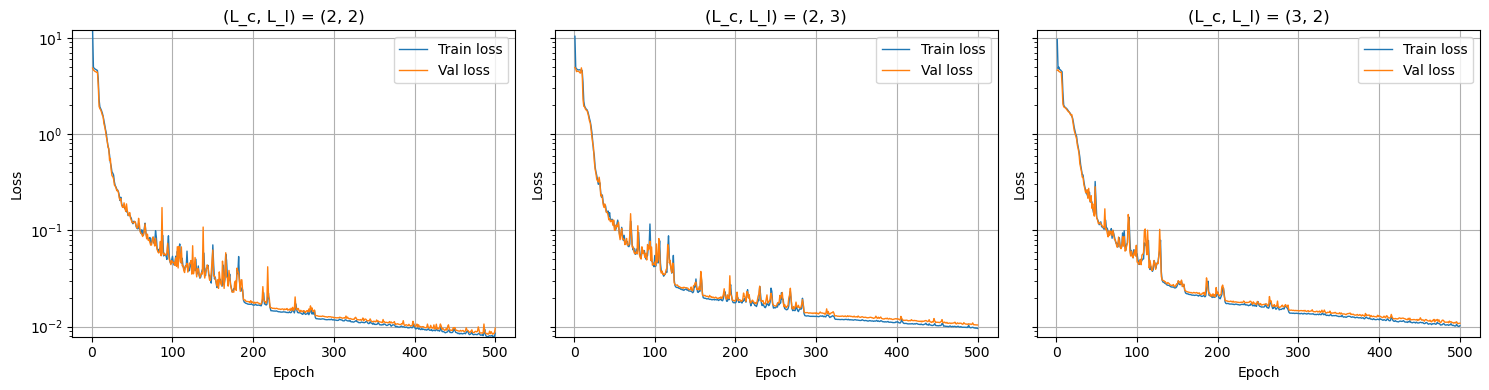

In [25]:
#Plot the graphs using a convolutional autoencoder

fig, ax = plt.subplots(1, 3 , figsize=(15, 4), sharey=True)
y_min = float('inf')
y_max = -float('inf')

for idx_conv, el in enumerate(Lc_Ll_list):
      
      plot(ax[idx_conv], train_losses_conv[idx_conv], val_losses_conv[idx_conv], num_epochs)
      ax[idx_conv].set_title(f"(L_c, L_l) = {el}")
      y_max = max(y_max, max(np.max(train_losses_conv[idx_conv]), np.max(val_losses_conv[idx_conv]), np.max(val_rel_losses_conv[idx_conv])))
      y_min = min(y_min, min(np.min(train_losses_conv[idx_conv]), np.min(val_losses_conv[idx_conv]), np.min(val_rel_losses_conv[idx_conv])))

for i in range(3):
      ax[i].set_ylim(y_min, y_max)

plt.tight_layout()
plt.show()

#### **Cross-validation over the best model**

In [26]:
k_fold = 5
k_indices=build_k_indices(len(params), k_fold)

train_loss_crossval=[]
val_loss_crossval=[]
val_rel_loss_crossval=[]

for k in range (0, k_fold):
    test_vel_k=solutions[k_indices[k,:]]
    train_params_k=params[np.delete(k_indices, k, axis=0).ravel()]
    train_vel_k=solutions[np.delete(k_indices, k, axis=0).ravel()]
    test_params_k=params[k_indices[k]]

    test_vel_k=normalize(test_vel_k, vel_space_min, vel_space_max, margin=0.05)
    train_vel_k=normalize(train_vel_k, vel_space_min, vel_space_max, margin=0.05)
    train_params_k=normalize(train_params_k, min_params, max_params)
    test_params_k=normalize(test_params_k, min_params, max_params)

    model_trained, train_loss_history, val_loss_history, val_rel_loss_history, train_loss_enc_dec_history, train_loss_solver_enc_history = run_training_solver_autoencoder(
        SolverPlusMLPAutoencoder(activation="gelu", L_enc_dec=best_L_enc_dec, dim_reduced=best_dim_reduced),
        best_num_epochs, best_lr, batch_size, train_params_k, train_vel_k, test_params_k, test_vel_k, device, vel_space_max, vel_space_min, weights=[1,1])

    train_loss_crossval.append(train_loss_history[-1])
    val_loss_crossval.append(val_loss_history[-1])
    val_rel_loss_crossval.append(val_rel_loss_history[-1])
    print("Optimization for optimization", k+1, "over", k_fold, "finished! Relative error:", val_rel_loss_history[-1])

Optimization for optimization 1 over 5 finished! Relative error: 0.024740730818265524
Optimization for optimization 2 over 5 finished! Relative error: 0.02563655307659736
Optimization for optimization 3 over 5 finished! Relative error: 0.025849709258629727
Optimization for optimization 4 over 5 finished! Relative error: 0.024543562283118565
Optimization for optimization 5 over 5 finished! Relative error: 0.024914746559583225


In [27]:
#Computing statistics over the k_fold
mean_train_loss=sum(train_loss_crossval)/k_fold
mean_val_loss=sum(val_loss_crossval)/k_fold
mean_val_rel_loss=sum(val_rel_loss_crossval)/k_fold
std_train_loss=np.std(train_loss_crossval)
std_val_loss=np.std(val_loss_crossval)
std_val_rel_loss=np.std(val_rel_loss_crossval)

print("The mean training loss is: ", mean_train_loss, "with a standard deviation of", std_train_loss)
print("The mean test loss is: ", mean_val_loss, "with a standard deviation of", std_val_loss)
print("The mean validation relative error is: ", mean_val_rel_loss, "with a standard deviation of", std_val_rel_loss)

#Final best model (pick arbitrarily the one trained on the last fold)
best_model=model_trained

The mean training loss is:  0.004318739312778538 with a standard deviation of 0.0013536849417643815
The mean test loss is:  0.00480048447011564 with a standard deviation of 0.001388115649570727
The mean validation relative error is:  0.02513706039923888 with a standard deviation of 0.0005130500804835991


---
## 3 Error Assessment & Visualization

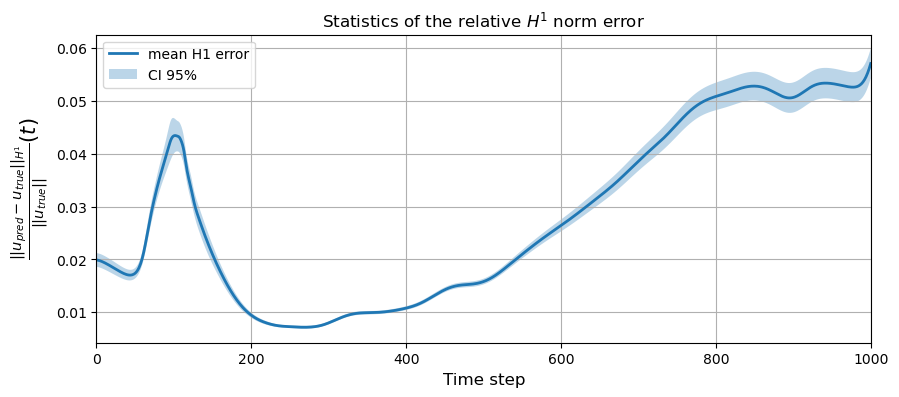

In [28]:
best_model.eval()

test_params = test_params.to(device)

with torch.no_grad():
    predicted_vels = model_trained.predict(test_params)
predicted_vels=predicted_vels.to("cpu")

N = len(test_params)

predicted_vels=denormalize(predicted_vels, vel_space_min, vel_space_max, margin=0.05)

true_vel=denormalize(test_vel, vel_space_min, vel_space_max, margin=0.05)

H1_space_norm_err = np.linalg.norm(np.matmul((true_vel-predicted_vels).numpy(), basis_time.T), axis=1)/np.linalg.norm(np.matmul(true_vel.numpy(), basis_time.T), axis=1)

mean_H1_err=np.mean(H1_space_norm_err, axis=0)
std_H1_err=np.std(H1_space_norm_err, axis=0)
err_inf=mean_H1_err-1.96/np.sqrt(N)*std_H1_err
err_sup=mean_H1_err+1.96/np.sqrt(N)*std_H1_err

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(np.arange(len(mean_H1_err)),mean_H1_err,label="mean H1 error", linewidth=2)
ax.fill_between(np.arange(len(mean_H1_err)), err_inf, err_sup, alpha=0.3, label='CI 95%')
ax.legend()
ax.set_xlabel("Time step", fontsize=12)
ax.set_ylabel(r'$\frac{||u_{pred}-u_{true}||_{H^1}}{||u_{true}||}(t)$', fontsize=15)
ax.set_title(r'Statistics of the relative $H^1$ norm error')
ax.set_xlim([0,len(mean_H1_err)])
ax.grid(True)

plt.show()

In [29]:
#Export output of a random sample in solutions/ to visualize the field in 3D (e.g. ParaView)

chosen_index=np.random.randint(0, len(test_params))
input_tensor = test_params[chosen_index,:]
input_tensor = input_tensor.unsqueeze(dim=0)
input_tensor = input_tensor.to(device)

with torch.no_grad():
    predicted_vel = model_trained.predict(input_tensor)
predicted_vel=predicted_vel[0]
predicted_vel=predicted_vel.to(device)
predicted_vel=denormalize(predicted_vel, vel_space_min, vel_space_max, margin=0.05)

visualize_solution(predicted_vel.to('cpu').numpy(), basis_space, basis_time, Nh_space, Nh_time, step_t=10)